In [1]:
#Import librerie

import numpy as np
import jax
from iminuit import Minuit
from jax import grad
from scipy.stats import chi2
import matplotlib.pyplot as plt
from iminuit.cost import LeastSquares

In [2]:
#Aree del picco a 511keV
'''
CSI = 5360.02
CSI_err = 21.01
BGO = 20101.57
BGO_err = 690.62
LYSO = 13484.85
LYSO_err = 24.68

aree = [CSI, BGO, LYSO]
aree_err = [CSI_err, BGO_err, LYSO_err]
'''

'\nCSI = 5360.02\nCSI_err = 21.01\nBGO = 20101.57\nBGO_err = 690.62\nLYSO = 13484.85\nLYSO_err = 24.68\n\naree = [CSI, BGO, LYSO]\naree_err = [CSI_err, BGO_err, LYSO_err]\n'

In [3]:
CSI = 5779.94
CSI_err = 93.86
BGO = 20314.60
BGO_err = 647.25
LYSO = 13743.66
LYSO_err = 582.62

aree = [CSI, BGO, LYSO]
aree_err = [CSI_err, BGO_err, LYSO_err]

In [4]:
#Z cristalli

CSI_Z = 54.0
CSI_Z_err = 0.
BGO_Z = 74.0
BGO_Z_err = 0.
LYSO_Z = 66.0
LYSO_Z_err = 0.

Z = [CSI_Z, BGO_Z, LYSO_Z]
Z_err = [CSI_Z_err, BGO_Z_err, LYSO_Z_err]

In [5]:
#Funzione di probabilità fotoelettrica

def photoelectric_probability(Z, C, n):
    return C * Z**n

In [6]:
#Fit della funzione con x=Z e y=area del picco
'''
jax.config.update("jax_enable_x64", True)

f_prime = jax.jit(grad(photoelectric_probability))

@jax.jit
def cost(C, n):
    result = 0.0
    for xi, yi, y_erri, x_erri in zip(Z, np.array(aree), Z_err, np.array(aree_err)):
        y_var = y_erri ** 2 + (f_prime(xi, C, n)*x_erri) ** 2
        result += (yi - photoelectric_probability(xi, C, n)) ** 2 / y_var
    return result

cost.errordef = Minuit.LEAST_SQUARES
'''

ls = LeastSquares(Z, aree, aree_err, photoelectric_probability)
my_minuit = Minuit(ls, C=1, n=4.5)
my_minuit.limits['n'] = (3, 5)
my_minuit.migrad()
my_minuit.hesse()
display(my_minuit)

# Calcolo del numero di gradi di libertà (ndof)
ndof = len(Z) - 2

# Calcolo del p-value utilizzando la distribuzione chi-quadro
p_value = (1. - chi2.cdf(my_minuit.fval, df=ndof))

# Calcolo del chi-quadro ridotto
chi_reduced = my_minuit.fval / ndof

print(f"p-value: {p_value}")
print(f"chi-quadro ridotto: {chi_reduced}")

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.846 (χ²/ndof = 1.8)      │              Nfcn = 210              │
│ EDM = 5.97e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ C    │  0.59e-3  │  0.25e-3  │            │            │         │         │       │
│ 1 │ n    │   4.04    │   0.10    │            │            │    3    │    5    │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────┐
│   │         C         n │
├───┼─────────────────────┤
│ C │  6.17e-08 -25.60e-6 │
│ n │ -25.60e-6    0.0106 │
└───┴─────────────────────┘

p-value: 0.17421006363875713
chi-quadro ridotto: 1.846336665762804


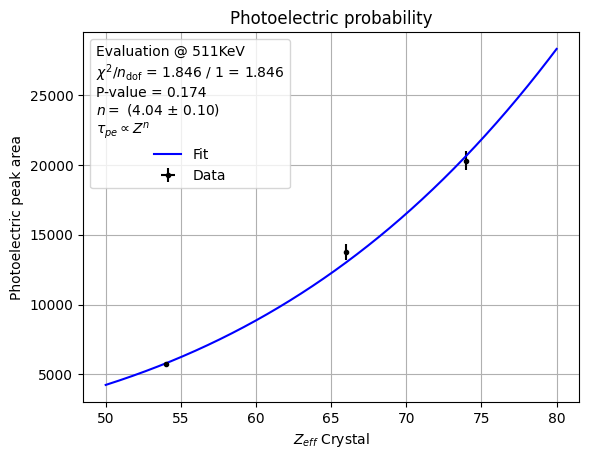

In [7]:
#Plot del fit

xaxis = np.linspace(50, 80, 10000)
#plt.figure(figsize=(8,8))
plt.errorbar(Z, aree, xerr=Z_err, yerr=aree_err, fmt='.', ecolor='black', label='Data', color='black')
plt.plot(xaxis, photoelectric_probability(xaxis, *my_minuit.values), label='Fit', color='blue')

fit_info = []
fit_info.append('Evaluation @ 511KeV')
fit_info.append(f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {my_minuit.fval:.3f} / {ndof:.0f} = {chi_reduced:.3f}")
fit_info.append(f"P-value = {p_value:.3f}")
#fit_info.append('$C = $ ({0:.2f} $\\pm$ {1:.2f})'.format(my_minuit.values['C'], my_minuit.errors['C']))
fit_info.append('$n = $ ({0:.2f} $\\pm$ {1:.2f})'.format(my_minuit.values['n'], my_minuit.errors['n']))
fit_info.append('${\\tau}_{pe} \\propto Z^n$')
plt.legend(title="\n".join(fit_info), frameon=True)
plt.grid(True)
plt.title('Photoelectric probability')
plt.xlabel('$Z_{eff}$ Crystal')
plt.ylabel('Photoelectric peak area')
#plt.yscale('log')
#save the image at medium resolution
plt.savefig('photoelectric_fit.png', dpi=600)